In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time

from torchvision import datasets, transforms
from tensorboardX import SummaryWriter
from model import Net, ConvNet
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64

import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)
torch.manual_seed(42)

In [3]:
# loading the dataset
# note that this time we do not perfrom the normalization operation, see next cell
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

In [4]:
class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.1307)/0.3081

# we load the body of the neural net trained last time...
model = torch.load('model.net', map_location='cpu') 

# ... and add the data normalization as a first "layer" to the network
# this allows us to search for adverserial examples to the real image, rather than
# to the normalized image
model = nn.Sequential(Normalize(), model)

# and here we also create a version of the model that outputs the class probabilities
model_to_prob = nn.Sequential(model, nn.Softmax())

# we put the neural net into evaluation mode (this disables features like dropout)
model.eval()
model_to_prob.eval()

/home/manu/git/riai18/assignments/ex3/.env/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/manu/git/riai18/assignments/ex3/.env/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/manu/git/riai18/assignments/ex3/.env/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has change

Sequential(
  (0): Sequential(
    (0): Normalize()
    (1): ConvNet(
      (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2_drop): Dropout2d(p=0.2)
      (fc1): Linear(in_features=128, out_features=100, bias=True)
      (fc2): Linear(in_features=100, out_features=10, bias=True)
      (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=Tru

In [5]:
# define a show function for later
def show(original, adv, model_to_prob):
    p0 = model_to_prob(original).detach().numpy()
    p1 = model_to_prob(adv).detach().numpy()
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(original.detach().numpy().reshape(28, 28), cmap='gray')
    axarr[0].set_title("Original, class: " + str(p0.argmax()))
    axarr[1].imshow(adv.detach().numpy().reshape(28, 28), cmap='gray')
    axarr[1].set_title("Original, class: " + str(p1.argmax()))
    print("Class\t\tOrig\tAdv")
    for i in range(10):
        print("Class {}:\t{:.2f}\t{:.2f}".format(i, float(p0[:, i]), float(p1[:, i])))

In [112]:
from IPython.core.debugger import set_trace

def fgsm(model, x, target, eps, targeted=True, clip_min=None, clip_max=None):
    """Internal process for all FGSM and PGD attacks. """    
    # create a copy
    x_tensor = x.clone().detach_()
    # enable gradient
    x_tensor.requires_grad_()
    # convert input target from integer into tensor
    target = torch.tensor([target])
    
    # run the net on our target
    net_output = model(x_tensor)
    
    # calculate loss with respect to target label
    # for targeted FGSM this is NOT the true label
    # for untargeted FGSM this is the true label
    criterion = nn.CrossEntropyLoss()
    loss = criterion(net_output, target)

    # take the gradient of the loss
    model.zero_grad() # zero the buffer
    loss.backward() # backpropagate
    grad = x_tensor.grad
    grad_sign = torch.sign(grad)
    
    # attack
    if targeted:
        x_perturbed = x_tensor - eps * grad_sign
    else:
        x_perturbed = x_tensor + eps * grad_sign
    
    # clip the ouput back to the image domain, for MNIST it is [0,1]
    if (clip_min is not None) or (clip_max is not None):
        x_perturbed.clamp_(min=clip_min, max=clip_max) # Inplace clamping of pytorch
    return x_perturbed


def fgsm_targeted(model, x, target, eps, clip_min=None, clip_max=None):
    """
    Targeted Fast Gradient Sign Method
    
    Args:
        model: Neural net
        x: Tensor of the given data
        target: Target label
        eps: Size of Perturbation

    Returns:
        Perturbated Tensor
    """
    
    return fgsm(model, x, target, eps, targeted=True, clip_min=None, clip_max=None)

def fgsm_untargeted(model, x, correct_label, eps, clip_min=None, clip_max=None):
    """
    Targeted Fast Gradient Sign Method
    
    Args:
        model: Neuralnet
        x: Tensor of the given data
        label: Correct label
        eps: Size of Perturbation

    Returns:
        Perturbated Tensor
    """
    return fgsm(model, x, correct_label, eps, targeted=False, clip_min=None, clip_max=None)

def pgd(model, x, target, k, eps, eps_step, targeted=True, clip_min=None, clip_max=None):
    """
    Projected gradient descent base function
    
    Args:
        model: Neuralnet
        x: Tensor of the given data
        target: Target label
        eps: Size of L_inf ball on which we will project down to.
        eps_step: Size of Perturbation used for the FGSM

    Returns:
        Perturbated Tensor
    """
    # Define the L_inf ball for the projection
    x_min = x - eps
    x_max = x + eps
    
    # FGSM step
    for i in range(k):
        adv = fgsm(model, x, target, eps_step, targeted=targeted, clip_min=None, clip_max=None)
        
        # Project on L_inf ball 
        adv = torch.max(x_min, adv) # If adv is inside the L_inf ball
        adv = torch.min(x_max, adv) # If adv is outside the L_inf ball
        x = adv
    
    # clip the ouput back to the image domain, for MNIST it is [0,1]
    if (clip_min is not None) or (clip_max is not None):
        adv.clamp_(min=clip_min, max=clip_max) # Inplace clamping of pytorch
    return adv    
    
    # project back to L_inf ball
    
    
def pgd_targeted(model, x, target, k, eps, eps_step, targeted=True, clip_min=None, clip_max=None):
    return pgd(model, x, target, k, eps, eps_step, targeted=True, clip_min=None, clip_max=None)

def pgd_untargeted(model, x, correct_label, k, eps, eps_step, targeted=False, clip_min=None, clip_max=None):
    return pgd(model, x, correct_label, k, eps, eps_step, targeted=False, clip_min=None, clip_max=None)


In [127]:
# try out our attacks
i_data = 1
target_label = 0
original = torch.unsqueeze(test_dataset[i_data][0], dim=0)
correct_label = test_dataset[i_data][1].item()

Class		Orig	Adv
Class 0:	0.00	0.34
Class 1:	0.00	0.00
Class 2:	1.00	0.01
Class 3:	0.00	0.20
Class 4:	0.00	0.00
Class 5:	0.00	0.05
Class 6:	0.00	0.00
Class 7:	0.00	0.00
Class 8:	0.00	0.39
Class 9:	0.00	0.00


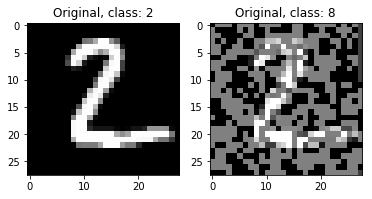

In [133]:
adv = fgsm_targeted(model, original, target_label, 5e-1, clip_min=0, clip_max=1.0)

show(original, adv, model_to_prob)

Class		Orig	Adv
Class 0:	0.00	0.00
Class 1:	0.00	0.00
Class 2:	1.00	0.00
Class 3:	0.00	1.00
Class 4:	0.00	0.00
Class 5:	0.00	0.00
Class 6:	0.00	0.00
Class 7:	0.00	0.00
Class 8:	0.00	0.00
Class 9:	0.00	0.00


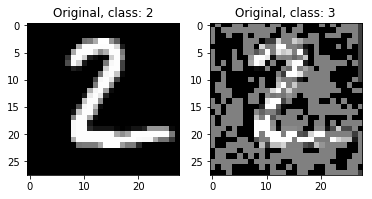

In [135]:
adv = fgsm_untargeted(model, original, correct_label, 5e-1,  clip_min=0, clip_max=1.0)

show(original, adv, model_to_prob)

Class		Orig	Adv
Class 0:	0.00	0.99
Class 1:	0.00	0.00
Class 2:	1.00	0.01
Class 3:	0.00	0.00
Class 4:	0.00	0.00
Class 5:	0.00	0.00
Class 6:	0.00	0.00
Class 7:	0.00	0.00
Class 8:	0.00	0.00
Class 9:	0.00	0.00


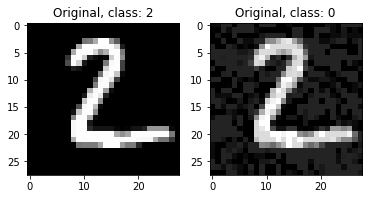

In [137]:
adv = pgd_targeted(model, original, target_label, 500, 0.08, 0.05, clip_min=0, clip_max=1.0)

show(original, adv, model_to_prob)

Class		Orig	Adv
Class 0:	0.00	0.00
Class 1:	0.00	0.00
Class 2:	1.00	0.00
Class 3:	0.00	1.00
Class 4:	0.00	0.00
Class 5:	0.00	0.00
Class 6:	0.00	0.00
Class 7:	0.00	0.00
Class 8:	0.00	0.00
Class 9:	0.00	0.00


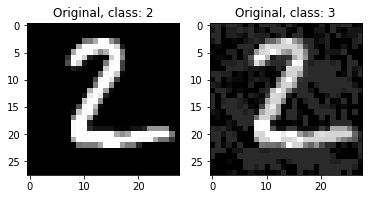

In [126]:
adv = pgd_untargeted(model, original, correct_label, 50, 0.1, 0.05, clip_min=0, clip_max=1.0)

show(original, adv, model_to_prob)

# Findings

As we can see PGD can create adverserial examples without perturbing the image as much as the FGSM method, with only a slightly increased computational payload.